# Feature Engineering & Modeling

Table of Contents:

- [Feature Engineering and Selection](#Feature-Engineering-and-Selection)
- [Scaling Variables](#Scaling-Variables)
- [Model Preparation](#Model-Preparation)
- [Machine Learning Models](#Machine-Learning-Models)
- [Visualization](#Visualization)

---


In [97]:
import pandas as pd
import time
import zipcodes
import numpy as np
import seaborn as sns
import pickle
from sklearn.cluster import KMeans, k_means
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import geopandas
import matplotlib.pyplot as plt
from geopy import distance

In [3]:
from mpl_toolkits.basemap import Basemap

In [4]:
df = pd.read_csv('../Data/yelp_dataset_final.csv')
df.drop('Index', 1, inplace=True)

## Feature Engineering and Selection
---

In [6]:
states_to_drop = ['NY','TX','CA','IN','VA','KY','CO','OR','IL','SC']
df = df[~df['STATE'].isin(states_to_drop)]
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df['target'].replace(5,4, inplace=True)

In [7]:
df.target.unique()

array([2, 4, 3, 1])

In [8]:
df.head()

,zip,yelp_dollar_1,yelp_dollar_2,yelp_dollar_3,yelp_dollar_4,Total_Business,STATE,income_level_1,income_level_2,income_level_3,income_level_4,income_level_5,income_level_6,target
0,15003,6,8,0,2,16,PA,2340.0,1650.0,820.0,450.0,360.0,40.0,2
1,15015,0,1,0,0,1,PA,160.0,70.0,60.0,70.0,190.0,110.0,4
2,15017,17,41,6,3,67,PA,2380.0,1930.0,1320.0,910.0,1330.0,520.0,2
3,15024,2,6,1,1,10,PA,1470.0,1050.0,650.0,490.0,630.0,180.0,2
4,15025,2,4,0,0,6,PA,2870.0,1740.0,1000.0,730.0,1200.0,370.0,2


In [9]:
df['lat'] = [zipcodes.matching(z)[0]['lat'] for z in df['zip'].astype(str)]
df['long'] = [zipcodes.matching(z)[0]['long'] for z in df['zip'].astype(str)]

In [10]:
df.head()

,zip,yelp_dollar_1,yelp_dollar_2,yelp_dollar_3,yelp_dollar_4,Total_Business,STATE,income_level_1,income_level_2,income_level_3,income_level_4,income_level_5,income_level_6,target,lat,long
0,15003,6,8,0,2,16,PA,2340.0,1650.0,820.0,450.0,360.0,40.0,2,40.59,-80.22
1,15015,0,1,0,0,1,PA,160.0,70.0,60.0,70.0,190.0,110.0,4,40.63,-80.08
2,15017,17,41,6,3,67,PA,2380.0,1930.0,1320.0,910.0,1330.0,520.0,2,40.35,-80.10
3,15024,2,6,1,1,10,PA,1470.0,1050.0,650.0,490.0,630.0,180.0,2,40.54,-79.80
4,15025,2,4,0,0,6,PA,2870.0,1740.0,1000.0,730.0,1200.0,370.0,2,40.29,-79.88


**What Happened?**

 - We drop the state of NY, TX, CA, IN, VA, KY, CO, OR, IL, and SC since they don't have a significant(very little) amount of businesses comparing to other states. 
 - We merged our target 5 with 4. Because, there were only four 5s in our dataset, to prevent outlier issue.



In [13]:
def insert_metro_center(df, metro, lat, long):
    mask = df['STATE'] == metro
    df.loc[mask, 'metro_lat'] = lat
    df.loc[mask, 'metro_long'] = long
    return df

In [28]:
df = insert_metro_center(df, 'NV', 36.1674, -115.1484)
df = insert_metro_center(df, 'NC', 28.8610, -98.7061)
df = insert_metro_center(df, 'PA', 40.4406, -79.9959)
df = insert_metro_center(df, 'OH', 41.505493, -81.681290)
df = insert_metro_center(df, 'AZ', 33.4488, -112.0770)

In [29]:
biz_lalo = list(zip(df['lat'],df['long']))
metro_lalo = list(zip(df['metro_lat'], df['metro_long']))

In [30]:
df['dist'] = [distance.distance(biz_lalo[i], metro_lalo[i]).miles for i in range(len(biz_lalo))]

In [31]:
df.head()

,zip,yelp_dollar_1,yelp_dollar_2,yelp_dollar_3,yelp_dollar_4,Total_Business,STATE,income_level_1,income_level_2,income_level_3,income_level_4,income_level_5,income_level_6,target,lat,long,metro_lat,metro_long,dist
0,15003,6,8,0,2,16,PA,2340.0,1650.0,820.0,450.0,360.0,40.0,2,40.59,-80.22,40.4406,-79.9959,15.669529
1,15015,0,1,0,0,1,PA,160.0,70.0,60.0,70.0,190.0,110.0,4,40.63,-80.08,40.4406,-79.9959,13.798219
2,15017,17,41,6,3,67,PA,2380.0,1930.0,1320.0,910.0,1330.0,520.0,2,40.35,-80.10,40.4406,-79.9959,8.320874
3,15024,2,6,1,1,10,PA,1470.0,1050.0,650.0,490.0,630.0,180.0,2,40.54,-79.80,40.4406,-79.9959,12.391193
4,15025,2,4,0,0,6,PA,2870.0,1740.0,1000.0,730.0,1200.0,370.0,2,40.29,-79.88,40.4406,-79.9959,12.057847


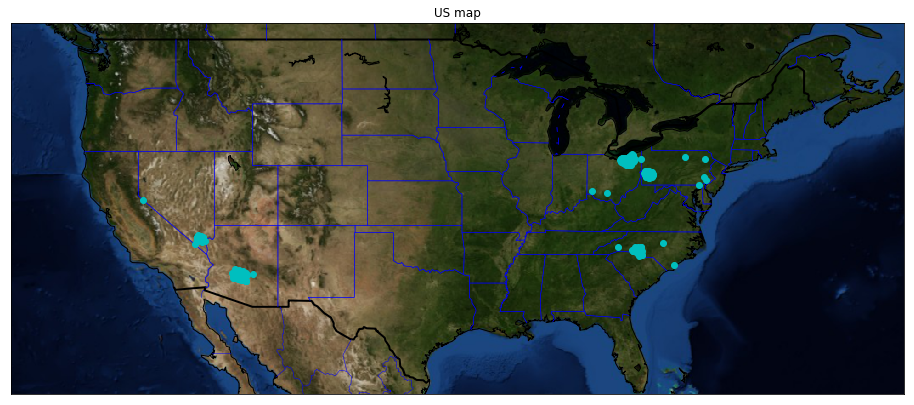

In [154]:
fig = plt.figure(figsize=(16, 16))
m = Basemap(projection='mill',
           llcrnrlat = 25,
           llcrnrlon = -130,
           urcrnrlat = 50,
           urcrnrlon = -60,
           resolution = 'l'
           )
m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates(color='b')
m.bluemarble()

for i in range(len(df['lat'])):
    lat = df['lat'].iloc[i]
    long = df['long'].iloc[i]
    xpt, ypt = m(long, lat)
    m.plot(xpt, ypt,'co')
    
plt.title('US map')
plt.show()

**What happened ?**

Yelp businesses were grouped by zip code for five of the largest US Metropolitan areas as available within the Yelp “Open Dataset” provided by Yelp.  The Metros are as follows:

- Phoenix, AZ 
- Cleveland, OH
- Pittsburgh, PA
- Las Vegas, NV
- Charlotte, NC

In turn, zip codes were converted to latitude and longitude by the Python Package Index [“Zipcodes”](https://pypi.org/project/zipcodes/). Finally, the matplotlib package, “Basemap” was used to project a map of the US and each zipcode latitude and longitude was plotted a light blue dot. Keep in mind, that the some of the smaller metros Yelp businesses are disproportionately represented making them inaccurately seem as large as Las Vegas or Phoenix.

Additionally, a feature was created which represents the distance of a zip code from the metro center. For each metro, it was decided that city hall would designate the metropolitan centroid for the respective city. Then, latitude and longitude of city hall was found using a google search. Distance between two pairs of latitude and longitude was calculated for each business using the Python GeoPy library.

---

## Scaling Variables

In [33]:
bias = 3
df['scaled_yelp_1'] = (df['yelp_dollar_1'] + bias) / (df['Total_Business']+4*bias)
df['scaled_yelp_2'] = (df['yelp_dollar_2'] + bias) / (df['Total_Business']+4*bias)
df['scaled_yelp_3'] = (df['yelp_dollar_3'] + bias) / (df['Total_Business']+4*bias)
df['scaled_yelp_4'] = (df['yelp_dollar_4'] + bias) / (df['Total_Business']+4*bias)


In [100]:
df.head()

,zip,yelp_dollar_1,yelp_dollar_2,yelp_dollar_3,yelp_dollar_4,Total_Business,STATE,income_level_1,income_level_2,income_level_3,...,target,lat,long,metro_lat,metro_long,dist,scaled_yelp_1,scaled_yelp_2,scaled_yelp_3,scaled_yelp_4
0,15003,6,8,0,2,16,PA,2340.0,1650.0,820.0,...,2,40.59,-80.22,40.4406,-79.9959,15.669529,0.321429,0.392857,0.107143,0.178571
1,15015,0,1,0,0,1,PA,160.0,70.0,60.0,...,4,40.63,-80.08,40.4406,-79.9959,13.798219,0.230769,0.307692,0.230769,0.230769
2,15017,17,41,6,3,67,PA,2380.0,1930.0,1320.0,...,2,40.35,-80.10,40.4406,-79.9959,8.320874,0.253165,0.556962,0.113924,0.075949
3,15024,2,6,1,1,10,PA,1470.0,1050.0,650.0,...,2,40.54,-79.80,40.4406,-79.9959,12.391193,0.227273,0.409091,0.181818,0.181818
4,15025,2,4,0,0,6,PA,2870.0,1740.0,1000.0,...,2,40.29,-79.88,40.4406,-79.9959,12.057847,0.277778,0.388889,0.166667,0.166667


Why scale our variables?
 - We scale our variables to avoid unrealistic distribution of the yelp dollar sign, if left alone, these algorithms only take in the magnitude of features neglecting the units. The results would vary greatly between different units. The features with high magnitudes will weigh in a lot more in the distance calculations than features with low magnitudes.
---

# Model Preparation

In [37]:
X = df[['scaled_yelp_1', 'scaled_yelp_2','scaled_yelp_3', 'scaled_yelp_4','Total_Business','dist']]
y = df['target']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Basedline Model

In [39]:
y.value_counts(normalize=True)

2    0.631929
3    0.219512
1    0.095344
4    0.053215
Name: target, dtype: float64

What is this ?
 - This is our baseline model. 0 to 4 represent the affluency, where 0 has the lowest affluency and 4 has the highest affluency. The majority of our target fall under 2. Our base goal is to fit our data into several models and get the accuracy score that is higher than 61.53%. In that case, we will know that our model are performing better than the baseline.

## Machine Learning Models
---

In [71]:
pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create space of candidate learning algorithms and their hyperparameters
search_space = [{'classifier': [LogisticRegression(solver='lbfgs', multi_class='multinomial')],
                 'classifier__C': np.logspace(0, 2, 6)},
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [10, 100, 1000],
                 'classifier__max_features': [1, 2, 3]},
                {'classifier': [KNeighborsClassifier()],
                 'classifier__n_neighbors': [1, 3, 5, 7, 10]}]

In [74]:
import warnings
warnings.filterwarnings("ignore")
gs = GridSearchCV(pipe, search_space, cv=5)
start_time = time.time()
best_model = gs.fit(X_train, y_train)
print(f'Time Spent: {round((time.time()-start_time))} seconds')

Time Spent: 15 seconds


In [75]:
gs.best_estimator_

Pipeline(memory=None,
     steps=[('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [76]:
gs.score(X_train, y_train)

0.6449704142011834

In [77]:
gs.score(X_test, y_test)

0.5929203539823009

In [79]:
gs.best_estimator_.named_steps.classifier.coef_

array([[-1.11727807e-01, -1.00904304e-01, -9.36760748e-02,
        -2.86055775e-02, -4.93004304e-04, -2.31677084e-04],
       [ 2.59218853e-01,  3.24911420e-01,  2.14993408e-01,
         1.84043427e-01,  7.62406857e-04,  6.39342380e-05],
       [ 7.08692249e-02,  6.47739599e-02,  2.30041744e-02,
        -2.34945931e-02,  7.06833092e-04,  5.64908962e-04],
       [-2.18360271e-01, -2.88781076e-01, -1.44321508e-01,
        -1.31943257e-01, -9.76235645e-04, -3.97166116e-04]])

In [80]:
gs.best_estimator_.named_steps.classifier.intercept_

array([-0.37862056,  1.0807744 ,  0.13403785, -0.83619168])

**Which Model and Why ?**
- We have created an pipeline that will perform our X features and y target through three different classifiers. (Random Forest Classifier, Logistic Regress, KNeighbors Classifier). 
- The reason we select the above three classifier models is because we can interpret the result it generates.
- After performing a Grid Search, Logistic Regression gave us the best result with the accuracy of 64.49%, which did performed better than our baseline model which is 63.19%. However, we have a high variance in our model since the test dataset gave us the result of 59.29%.
- Also, we can tell by the intercept that our model is bias towards target 2 (1.08) followed by target 3 (0.13), and our target 1 and 4 have negative intercept.


## Visualization
---

In [105]:
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
lr.fit(X_train, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [128]:
feat_importance = pd.DataFrame(np.exp(lr.coef_[0]), X_train.columns, columns=['importance'])
feat_importance_1 = pd.DataFrame(np.exp(lr.coef_[1]), X_train.columns, columns=['importance'])
feat_importance_2 = pd.DataFrame(np.exp(lr.coef_[2]), X_train.columns, columns=['importance'])
feat_importance_3 = pd.DataFrame(np.exp(lr.coef_[3]), X_train.columns, columns=['importance'])

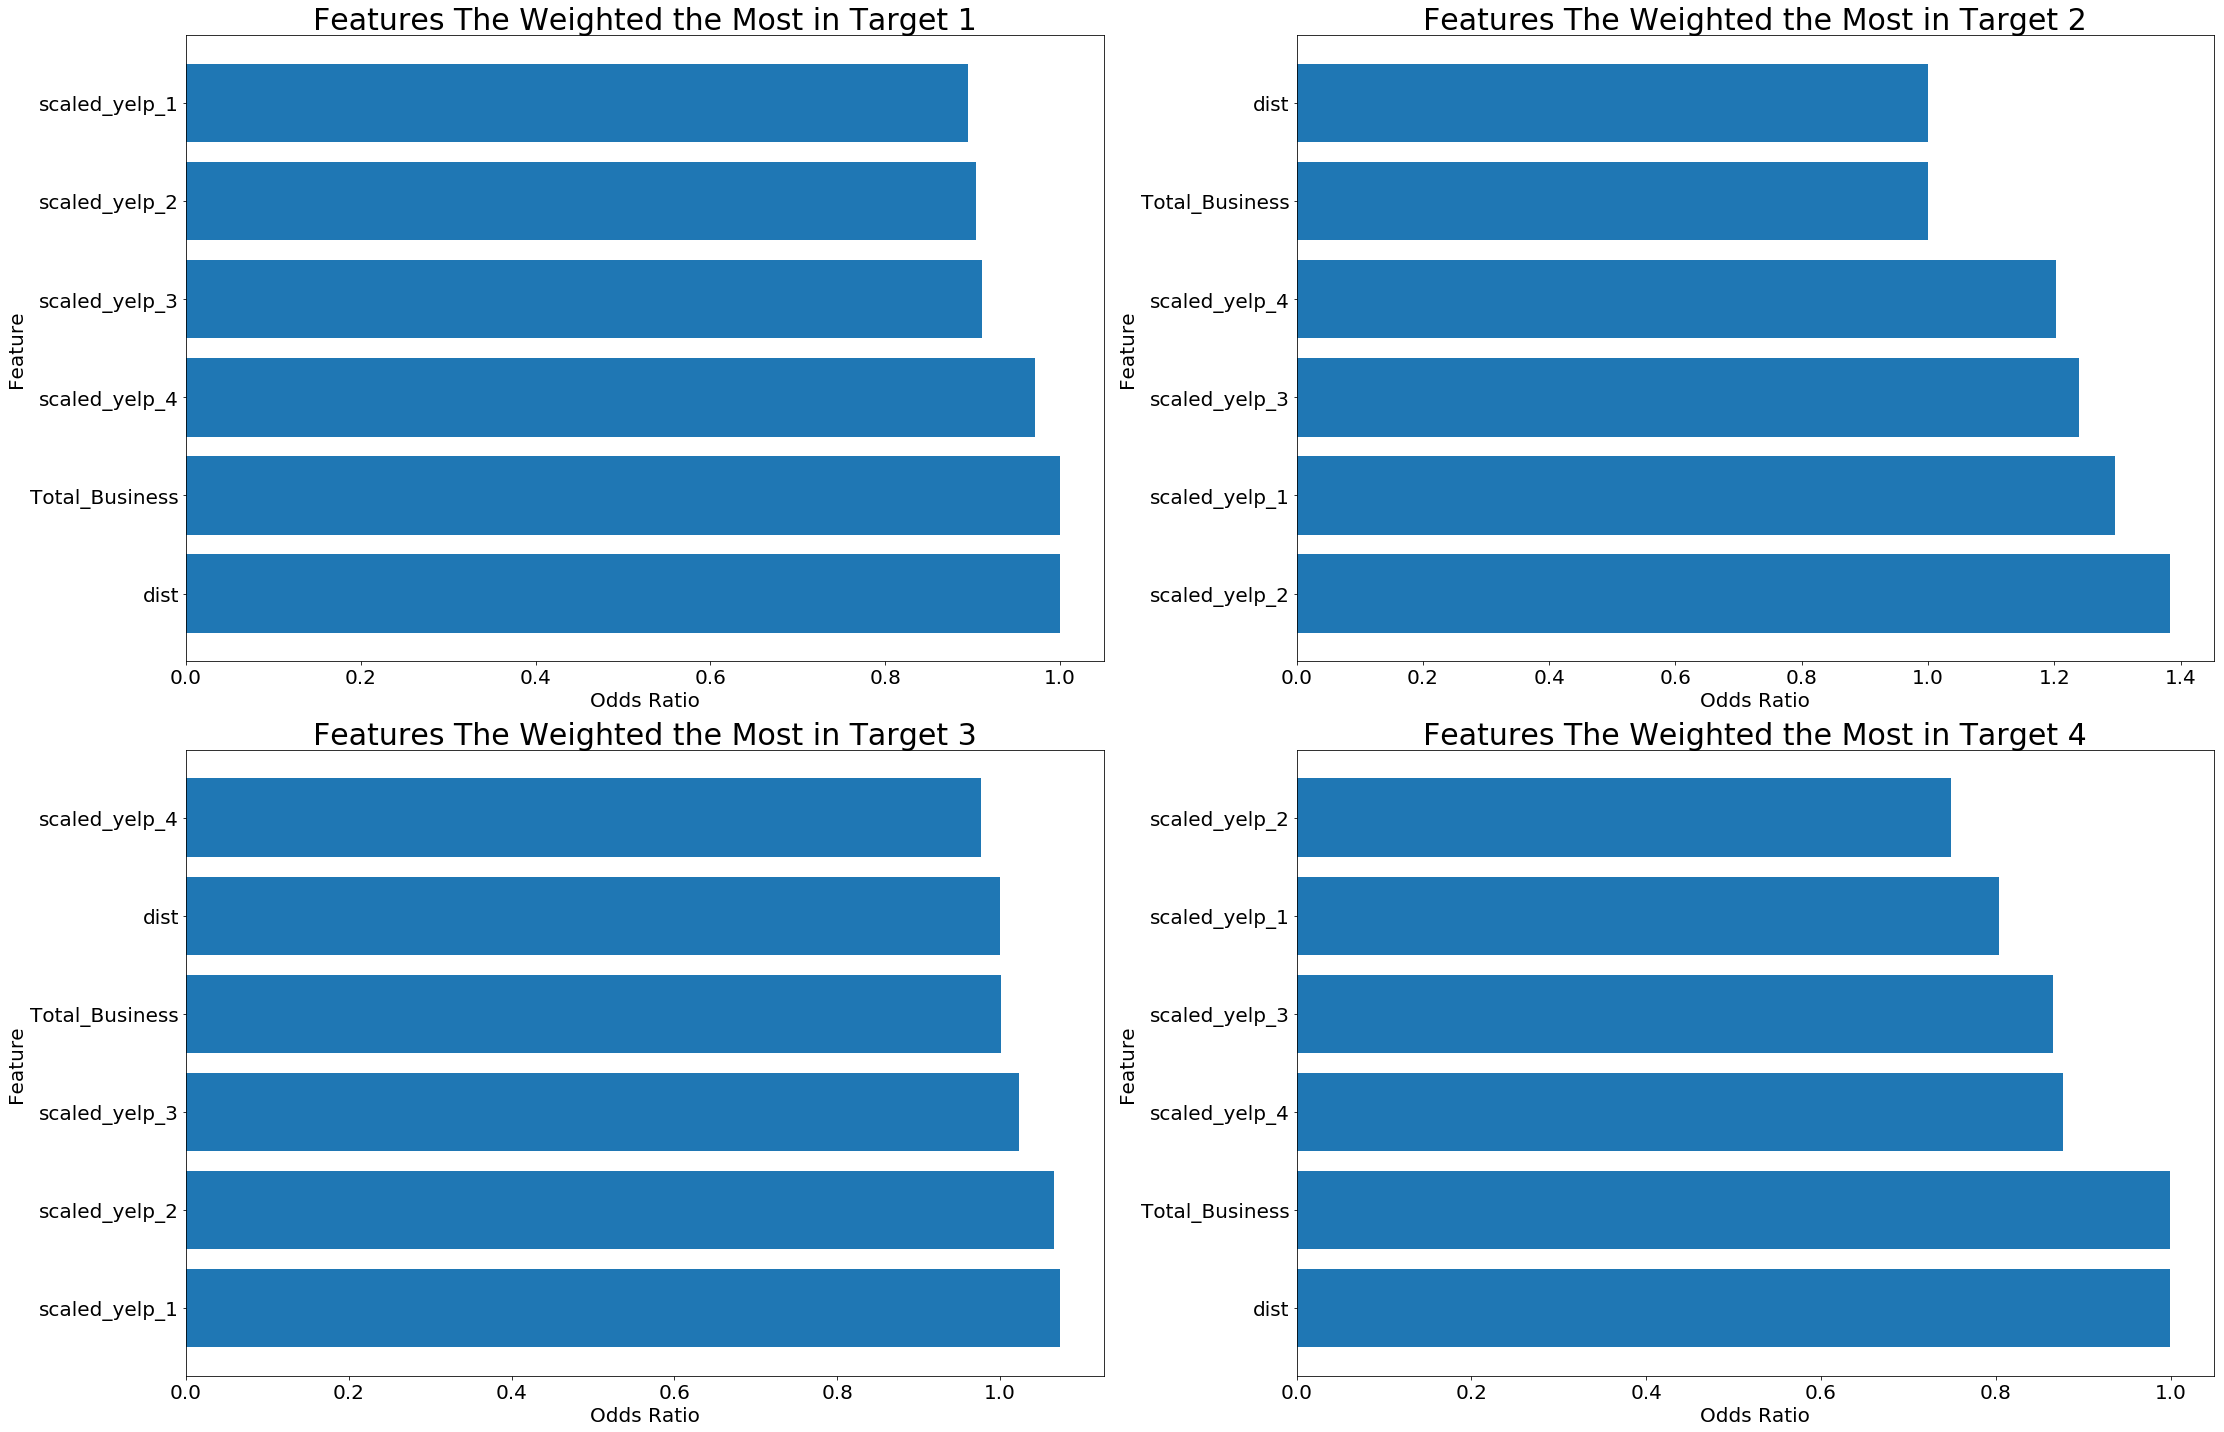

In [152]:
plt.figure(figsize=(31,20))

plt.subplot(2, 2, 1)
temp = feat_importance.sort_values('importance', ascending=False)
plt.barh(temp.index, temp['importance'])
plt.title('Features The Weighted the Most in Target 1', fontsize=30)
plt.xlabel('Odds Ratio', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.subplot(2, 2, 2)
temp = feat_importance_1.sort_values('importance', ascending=False)
plt.barh(temp.index, temp['importance'])
plt.title('Features The Weighted the Most in Target 2', fontsize=30)
plt.xlabel('Odds Ratio', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.subplot(2, 2, 3)
temp = feat_importance_2.sort_values('importance', ascending=False)
plt.barh(temp.index, temp['importance'])
plt.title('Features The Weighted the Most in Target 3', fontsize=30)
plt.xlabel('Odds Ratio', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.subplot(2, 2, 4)
temp = feat_importance_3.sort_values('importance', ascending=False)
plt.barh(temp.index, temp['importance'])
plt.title('Features The Weighted the Most in Target 4', fontsize=30)
plt.xlabel('Odds Ratio', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.tight_layout()
plt.show();


**What does the graph represent ?**
- The bar chart above It represent how many times the words are more likely to fall into our target class. 
 - by looking at target 1. We can deduced that distance weighted the most, however, our prediction was scaled yelp 1, so this isn't the accurate result we were hoping
 - by looking at target 2. We can deduced that scaled yelp 2 weighted the most, which is correct. We were estimating that place with scaled yelp 2 will have more target 2. 
 - by looking at target 3. We can deduced that scaled yelp 1 weighted the most, however, this doesn't match to our hypothesis.
 - target 4 has the similar result with target 1; therefore this isn't the best.
 



In [153]:
with open('../assets/gs_model.pkl', 'wb+') as f:
    pickle.dump(gs, f)